In [1]:
import models_nick

In [4]:
%pip install requests

   ---------------------------------------- 0.0/62.6 kB ? eta -:--:--
   ---------------------------------------- 62.6/62.6 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/163.8 kB ? eta -:--:--
   ---------------------------------------- 163.8/163.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/100.4 kB ? eta -:--:--
   ---------------------------------------- 100.4/100.4 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/66.8 kB ? eta -:--:--
   ---------------------------------------- 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/121.1 kB ? eta -:--:--
   ---------------------------------------- 121.1/121.1 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
#ophalen van KNMI data van het jaar 2023 van het station 344:Rotterdam en de vars:TG (Gemiddelde temp)
import requests
url = "https://www.daggegevens.knmi.nl/klimatologie/daggegevens"

params = {'start': '20150101', 'end': '20231231', 'stns':'344', 'vars':'TG', 'fmt':'json'}

weather_rotterdam_json = requests.get(url, params=params)

if weather_rotterdam_json.status_code == 200:
    print(weather_rotterdam_json.text)
    result = weather_rotterdam_json.text
else:
    print("Error:", weather_rotterdam_json.status_code)


[{"station_code":344,"date":"2015-01-01T00:00:00.000Z","TG":37},{"station_code":344,"date":"2015-01-02T00:00:00.000Z","TG":74},{"station_code":344,"date":"2015-01-03T00:00:00.000Z","TG":45},{"station_code":344,"date":"2015-01-04T00:00:00.000Z","TG":33},{"station_code":344,"date":"2015-01-05T00:00:00.000Z","TG":32},{"station_code":344,"date":"2015-01-06T00:00:00.000Z","TG":30},{"station_code":344,"date":"2015-01-07T00:00:00.000Z","TG":44},{"station_code":344,"date":"2015-01-08T00:00:00.000Z","TG":69},{"station_code":344,"date":"2015-01-09T00:00:00.000Z","TG":98},{"station_code":344,"date":"2015-01-10T00:00:00.000Z","TG":92},{"station_code":344,"date":"2015-01-11T00:00:00.000Z","TG":66},{"station_code":344,"date":"2015-01-12T00:00:00.000Z","TG":86},{"station_code":344,"date":"2015-01-13T00:00:00.000Z","TG":84},{"station_code":344,"date":"2015-01-14T00:00:00.000Z","TG":48},{"station_code":344,"date":"2015-01-15T00:00:00.000Z","TG":81},{"station_code":344,"date":"2015-01-16T00:00:00.000Z",

In [58]:
import pandas as pd
pd.read_json(result)
df = pd.read_json(result)
df['TG'] = df['TG']/10
df2023 = df.loc[df['date']>'20230101']
df2022 = df.loc[(df['date']<'20230101') & (df['date']>'20220101')]


C:\Users\Bobbie\AppData\Local\Temp\ipykernel_2844\647423029.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_json(result)
C:\Users\Bobbie\AppData\Local\Temp\ipykernel_2844\647423029.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(result)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


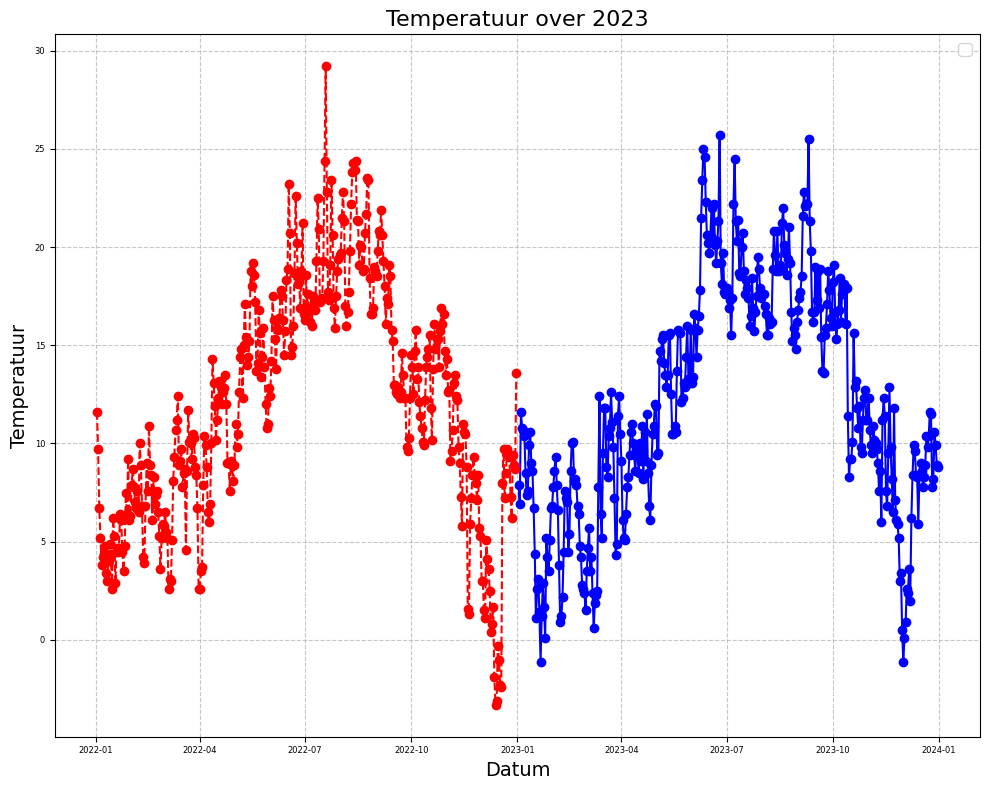

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))  # Figuurgrootte instellen
plt.plot(df2023['date'], df2023['TG'], marker='o', linestyle='-', color='b')
plt.plot(df2022['date'], df2022['TG'], marker='o', linestyle='--', color='r')
plt.title('Temperatuur over 2023', fontsize=16)  # Titel instellen
plt.xlabel('Datum', fontsize=14)  # X-as label instellen
plt.ylabel('Temperatuur', fontsize=14)  # Y-as label instellen
plt.xticks(fontsize=6)  # X-as tick labels grootte instellen
plt.yticks(fontsize=6)  # Y-as tick labels grootte instellen
plt.grid(True, linestyle='--', alpha=0.7)  # Raster toevoegen
plt.legend(fontsize=12)  # Legenda toevoegen
plt.tight_layout()  # Lay-out optimaliseren

# Grafiek weergeven
plt.show()

In [61]:
df = df.reset_index()
df = df.drop("date", axis = 1)
df = df.drop("station_code", axis = 1)


KeyError: "['date'] not found in axis"

In [68]:

df = df.drop('level_0', axis = 1)
df.columns = ["Day", "Temp"]


KeyError: "['level_0'] not found in axis"

In [69]:
df

,Day,Temp
0,0,3.7
1,1,7.4
2,2,4.5
3,3,3.3
4,4,3.2
...,...,...
3282,3282,8.2
3283,3283,10.6
3284,3284,9.9
3285,3285,8.9
